# Imports

In [45]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', palette='deep')

from sklearn.preprocessing import LabelEncoder, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

# Загрузка данных и предварительный анализ

Загрузим датасет и посмотрим что внутри

In [46]:
df = pd.read_csv("abalone.data", 
                 names=['sex',  # M, F, and I (infant) 
                        'length',  # Longest shell measurement, mm
                        'diameter',  # perpendicular to length, mm
                        'height',  # with meat in shell, mm
                        'whole_weight',  # whole abalone, grams
                        'shucked_weight',  # weight of meat, grams
                                           # очищенный вес - вес мяса
                        'viscera_weight',  # gut weight (after bleeding), grams
                                           # вес внутренностей - вес кишечника (после кровотечения)
                        'shell_weight',  # after being dried, grams 
                                         # вес скорлупы - после сушки
                        'rings'  # +1.5 gives the age in years
                 ])
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [48]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Пропусков нет, посмотрим распределение

In [49]:
orig_num_features = ["length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight"]
target = ["rings"]

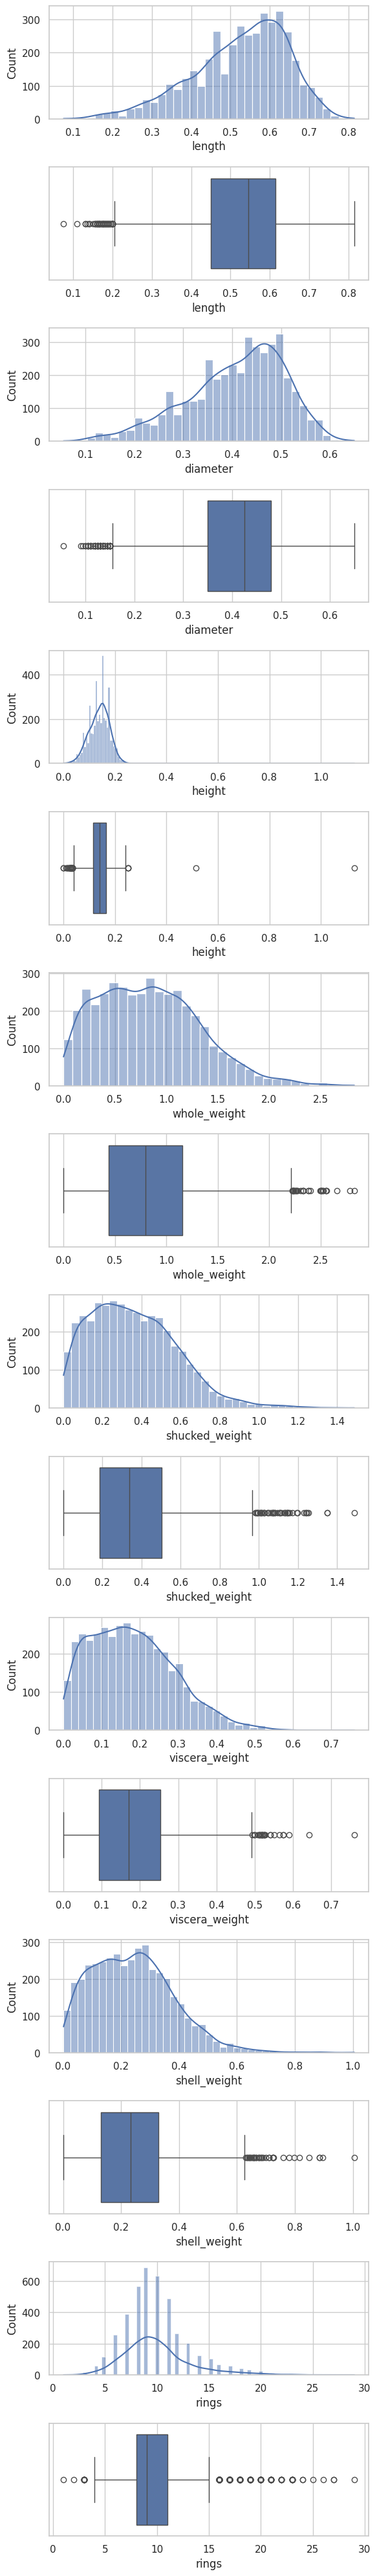

In [50]:
n_rows = len(orig_num_features + target) * 2
n_cols = 1
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6, 40))

for ax, feature in enumerate(orig_num_features + target):
    row = ax * 2
    sns.histplot(data=df, x=feature, kde=True, ax=axes[row])
    sns.boxplot(data=df, x=feature, ax=axes[row+1])
    # axs[row][col].set_title(feature)
    
plt.tight_layout()

plt.show()

Все численные показатели не центрированы и имеют выбросы. 
Данный факт следует учесть в дальнейшем при масштабировании фич.
Планирую применить PowerTransformer или QuantileTransformer

Построим корреляционную матрицу

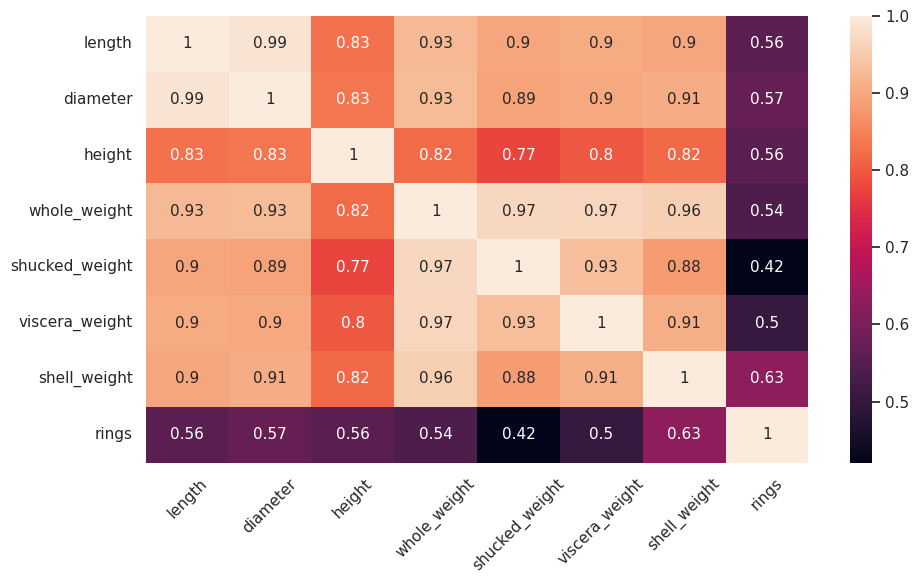

In [51]:
plt.figure(figsize=(10, 6))

corr_matrix = df[orig_num_features + target].corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":11})

plt.ylabel('')
plt.xlabel('')
plt.title('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Наблюдаем ярко выраженную мультиколлинеарность фич. 
Это может стать проблемой для задачи линейной регрессии. 
Ожидаю лучшие результаты от "К-ближайших соседей".
Интересно будет сравнить результаты на наборе фич "как есть", 
а также после удаления части коллинеарных фич. 

Посмотрим на количественную характеристику нашей категориальной фичи "sex"

In [52]:
df["sex"].describe()

count     4177
unique       3
top          M
freq      1528
Name: sex, dtype: object

<Axes: xlabel='sex', ylabel='percent'>

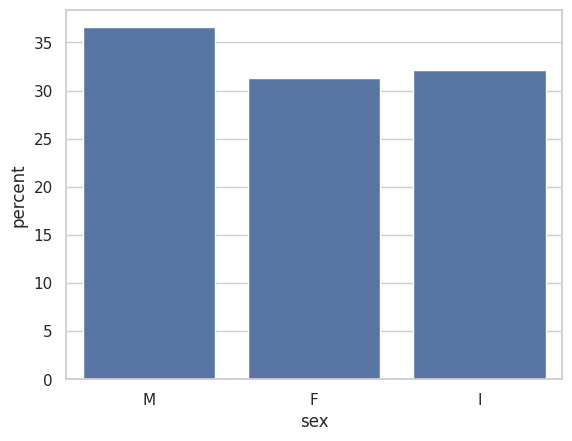

In [53]:
sns.countplot(data=df, x = "sex", stat="percent")

Никакое из значений не является редким, все представлены приблизительно в равной пропорции.
Данный факт следует учитывать при кодировании данного категориального признака.

# Feature engineering

Посчитаем объем (условно) моллюска (длина Х диаметр Х толщина). 
Понятно, что ракушка не прямоугольная, но нам важно получить новую фичу, 
имеющую физический смысл, но отличающуюся от исходных. 

In [54]:
df["volume"] = df["length"] * df["diameter"] * df["height"]
drop_indexes = df[df["volume"] == 0].index
df.drop(drop_indexes, inplace=True)

Гипотеза: мужские/женские/детские особи растут по-разному и могут отличаться плотностью.
Как вариант, плотностью: общей, мяса, ракушки.
Посчитаем эти плотности и посмотрим что получилось.

In [55]:
df["whole_density"] = df["whole_weight"] / df["volume"]
df.groupby(by="sex")["whole_density"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,1307.0,24.238216,7.010923,3.254380,21.890640,23.754789,25.693801,245.287521
I,1340.0,24.947863,4.786719,7.584715,22.270512,24.190729,26.660812,69.176214
M,1528.0,24.576914,3.486323,10.773268,22.402843,24.280766,26.262180,53.856942


Глядя в цифры, не похоже, чтобы плотности различных особей отличались.

Посмотрим на графиках

In [56]:
def plot_feature_distribution(feature_name):
    scaler = QuantileTransformer(output_distribution="normal", random_state=42)
    # scaler = PowerTransformer(method="box-cox", standardize=False)
    # scaler = RobustScaler(with_centering=True, with_scaling=True)
    scaled_feature = scaler.fit_transform(df[[feature_name]])
    scaled_feature_as_df = pd.DataFrame(scaled_feature, columns=scaler.get_feature_names_out())
    data = pd.concat([df[["sex", "rings"]], scaled_feature_as_df], axis=1)
    # sns.lmplot(x="rings", y="whole_density", data=data, hue="sex", fit_reg=False);
    sns.jointplot(x="rings", y=feature_name, data=data, hue="sex")

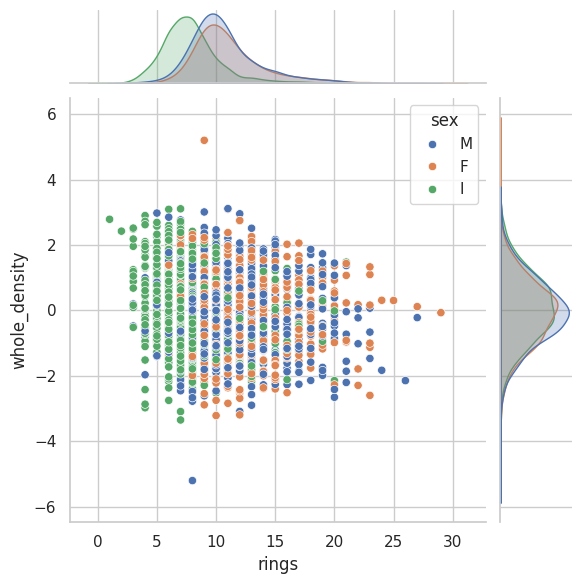

In [57]:
plot_feature_distribution("whole_density")

Да, действительно, по плотности их не разделить.
Посмотрим на остальные варианты плотности: мясо к объему и масса раковины к объему

In [58]:
df["shucked_density"] = df["shucked_weight"] / df["volume"]
df.groupby(by="sex")["shucked_density"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,1307.0,10.289496,3.445073,1.818946,8.828457,10.014677,11.406141,108.486439
I,1340.0,11.068487,4.651237,5.369016,9.224971,10.557307,12.119242,125.435540
M,1528.0,10.606793,2.171544,4.161408,9.096181,10.419715,11.932252,22.234432


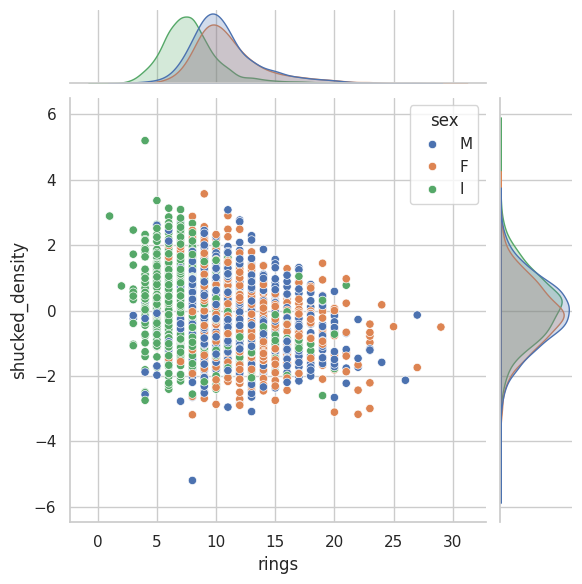

In [59]:
plot_feature_distribution("shucked_density")

In [60]:
df["shell_density"] = df["shell_weight"] / df["volume"]
df.groupby(by="sex")["shell_density"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,1307.0,7.039327,1.901519,0.731414,6.237902,6.819518,7.551545,61.189321
I,1340.0,7.460477,1.713257,4.317304,6.607625,7.205036,7.924112,36.363636
M,1528.0,7.122512,1.304840,2.495888,6.260473,6.890985,7.739285,16.830295


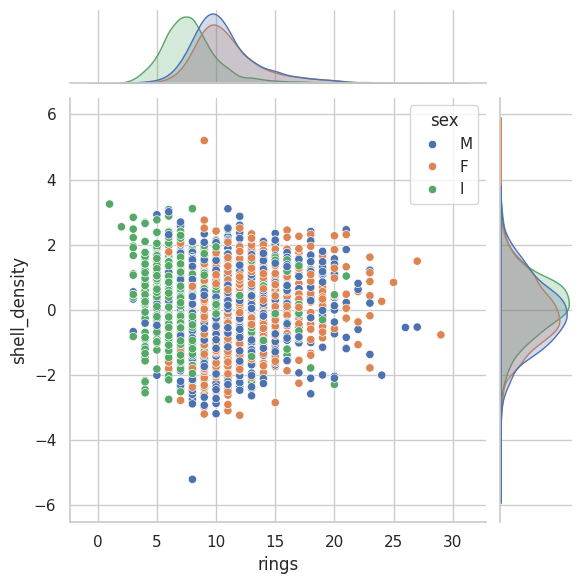

In [61]:
plot_feature_distribution("shell_density")

Распределение отношения массы раковины к общему объему (условно - плотность раковины) 
имеет едва уловимые отличия для особей различного пола. 

Выдвинем еще одну гипотезу: у особей разного пола разное соотношение 
массы мяса (раковины) к общей массе моллюска

In [62]:
df["shucked_rate"] = df["shucked_weight"]/df["whole_weight"]
df.groupby(by="sex")["shucked_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,1307.0,0.423298,0.053773,0.241405,0.390298,0.425926,0.459543,0.640794
I,1340.0,0.443240,0.167951,0.277913,0.402595,0.433490,0.468617,4.691943
M,1528.0,0.430688,0.056617,0.175258,0.391864,0.433441,0.470718,0.666543


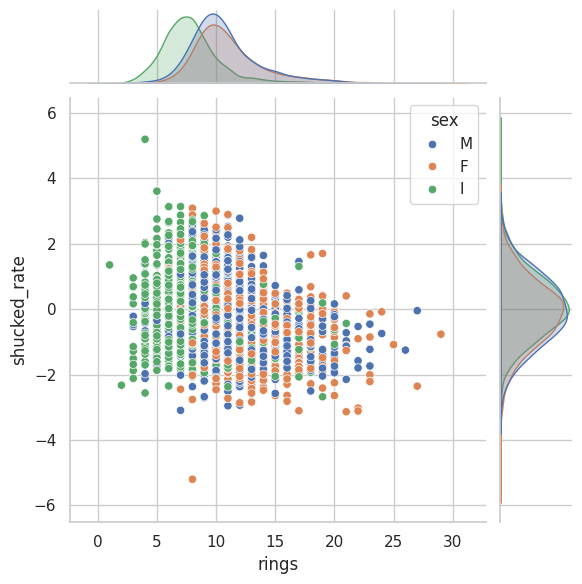

In [63]:
plot_feature_distribution("shucked_rate")

In [64]:
df["viscera_rate"] = df["viscera_weight"]/df["whole_weight"]
df.groupby(by="sex")["viscera_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,1307.0,0.221365,0.030725,0.097780,0.202010,0.221154,0.240081,0.431111
I,1340.0,0.215829,0.041354,0.007634,0.194014,0.212445,0.233324,0.665399
M,1528.0,0.218508,0.030141,0.118885,0.199758,0.217640,0.236623,0.391717


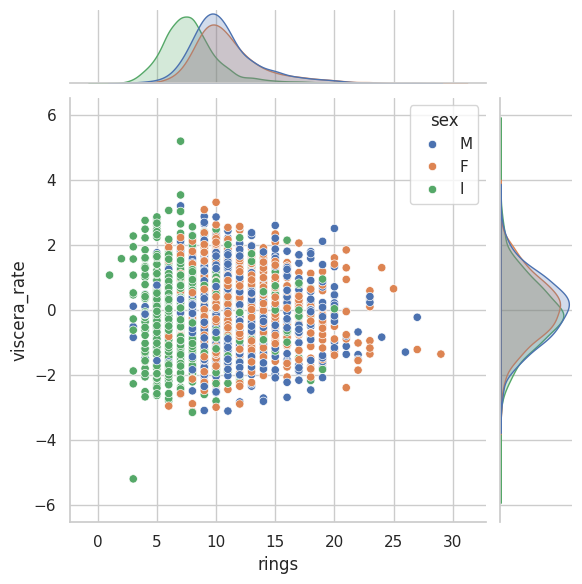

In [65]:
plot_feature_distribution("viscera_rate")

In [66]:
df["shell_rate"] = df["shell_weight"]/df["whole_weight"]
df.groupby(by="sex")["shell_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,1307.0,0.292473,0.041409,0.122155,0.264865,0.289308,0.317585,0.471651
I,1340.0,0.301674,0.051910,0.109341,0.274441,0.297253,0.321361,0.935361
M,1528.0,0.291461,0.045142,0.123740,0.260325,0.286664,0.318866,0.554340


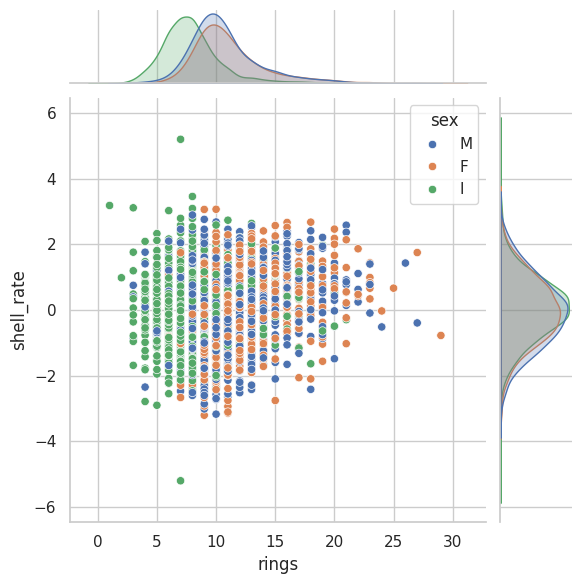

In [67]:
plot_feature_distribution("shell_rate")

Из полученных выше фич (shucked_rate, viscera_rate, shell_rate) оставим первую - 
соотношение массы мяса к общей массе моллюска 

# KNeighborsRegressor

## Подготовка данных

Перекодируем наш категориальный признак "sex"

In [68]:
encoder = LabelEncoder()
df['sex_le'] = encoder.fit_transform(df['sex'])

Выделим те фичи, с которыми будем дальше работать

In [69]:
orig_features = ["sex_le"] + orig_num_features
selected_features = ["sex_le", "volume", "shell_density", "shucked_rate"]
target = ["rings"]

Посмотрим, удалось ли нам избавиться от коллинеарности 

<Axes: >

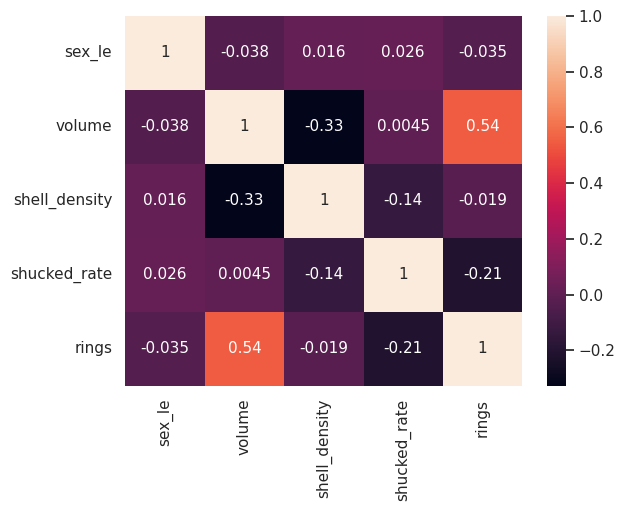

In [70]:
corr_matrix = df[selected_features + target].corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":11})

### Формирование датасета
Выделяем ту часть исходного датасета, с которой будем дальше работать

In [71]:
X = df[orig_features]
y = df[target]

Выполним кросс-валидацию на сырых данных

In [72]:
model = KNeighborsRegressor()

In [73]:
cv_results = cross_validate(model, X, y, cv=3)
print(cv_results["test_score"])

[0.46269425 0.50590302 0.47608586]


### Масштабирование
Поскольку в данных имеются выбросы, применим QuantileTransformer

In [74]:
# scaler = PowerTransformer(method="box-cox")
scaler = QuantileTransformer(output_distribution="normal", random_state=42)
X = scaler.fit_transform(X)

Разобъем выборку на тренировочную и тестовую части

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Получение и оценка результата на дефолтной модели

Тренируем модель с параметрами по умолчанию

In [76]:
model.fit(X_train, y_train)

KNeighborsRegressor()

Посмотрим на метрики модели на тренировочных данных

In [77]:
y_train_predicted = model.predict(X_train)

r2 = r2_score(y_train, y_train_predicted)
rmse = mean_squared_error(y_train, y_train_predicted, squared=False)
print(r2, rmse, sep="\n")

0.646791371766988
1.9001819142713021


Посмотрим на метрики модели на тестовых данных

In [78]:
y_test_predicted = model.predict(X_test)

r2 = r2_score(y_test, y_test_predicted)
rmse = mean_squared_error(y_test, y_test_predicted, squared=False)
print(r2, rmse, sep="\n")

0.4926450470164
2.339828303194013


С тестовыми данными модель справилась несколько хуже, чем с тренировочными.
Попробуем подобрать гиперпараметры

## Подбор гиперпараметров

In [79]:
model = KNeighborsRegressor()

parameters = {
    "n_neighbors": [*range(3, 10, 2)],
    "weights": ["uniform", "distance"],
    "algorithm": ["brute", "kd_tree", "ball_tree"],
    "p": [1, 2, 3]
}

# Создаем объект grid_search и обучаем его на тренировочных данных:
grid_search = GridSearchCV(model, parameters, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Получаем модель с наилучшей комбинацией параметров:
best_model = grid_search.best_estimator_

# Выводим найденную модель на экран
best_model

KNeighborsRegressor(algorithm='brute', n_neighbors=9, weights='distance')

In [80]:
# Проверяем модель с лучшими гиперпараметрами на тестовой выборке
y_test_predicted = best_model.predict(X_test)

# Выводим метрики
r2 = r2_score(y_test, y_test_predicted)
rmse = mean_squared_error(y_test, y_test_predicted, squared=False)
print(r2, rmse, sep="\n")

0.5114511535107538
2.296053661814063


Метрики модели несколько улучшились по сравнению с дефолтными параметрами, 
но все равно они ниже, чем на обучающей выборке

Попробуем прогнать через нашу модель те фичи, которые мы придумали сами 

In [81]:
# Выделяем фичи и таргет
X = df[selected_features]
y = df[target]

# Масштабируем данные
scaler = QuantileTransformer(output_distribution="normal", random_state=42)
X = scaler.fit_transform(X)

# Разбиваем выборку на тренировочную и тестовую части
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Тренируем модель с параметрами по умолчанию
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# Проверяем модель на тестовой выборке
y_test_predicted = model.predict(X_test)

# Выводим метрики
r2 = r2_score(y_test, y_test_predicted)
rmse = mean_squared_error(y_test, y_test_predicted, squared=False)
print(r2, rmse, sep="\n")

# Подбор гиперпараметров
parameters = {
    "n_neighbors": range(3, 10, 2),
    "weights": ["uniform", "distance"],
    "algorithm": ["brute", "kd_tree", "ball_tree"],
    "p": [1, 2, 3]
}

# Создаем объект grid_search и обучаем его на тренировочных данных:
grid_search = GridSearchCV(model, parameters, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Получаем модель с наилучшей комбинацией параметров:
best_model = grid_search.best_estimator_

# Выводим найденную модель на экран
best_model

0.5191609390010996
2.2778646137826244


KNeighborsRegressor(algorithm='brute', n_neighbors=9, p=3)

In [82]:
# Проверяем модель с лучшими гиперпараметрами на тестовой выборке
y_test_predicted = best_model.predict(X_test)

# Выводим метрики
r2 = r2_score(y_test, y_test_predicted)
rmse = mean_squared_error(y_test, y_test_predicted, squared=False)
print(r2, rmse, sep="\n")

0.5612898057770925
2.1757896215115187


Результат немного улучшился, но не радикально.

# KNeighborsClassifier

## Подготовка данных

In [83]:
cls_features = ["volume", "shell_density", "shucked_rate", "rings"]
cls_target = ["sex_le"]

In [84]:
# Выделяем фичи и таргет
X = df[cls_features]
y = df[cls_target].to_numpy().ravel()

# Масштабируем данные
scaler = QuantileTransformer(output_distribution="normal", random_state=42)
X = scaler.fit_transform(X)

# Разбиваем выборку на тренировочную и тестовую части
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Получение и оценка результата на дефолтной модели

In [85]:
# Тренируем модель с параметрами по умолчанию
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [86]:
# Проверяем как модель научилась на тренировочной выборке
y_train_predicted = model.predict(X_train)

# Выводим метрики
print(classification_report(y_true=y_train, y_pred=y_train_predicted))

              precision    recall  f1-score   support

           0       0.58      0.67      0.62       934
           1       0.73      0.78      0.75       930
           2       0.68      0.54      0.60      1058

    accuracy                           0.66      2922
   macro avg       0.66      0.66      0.66      2922
weighted avg       0.66      0.66      0.66      2922


In [87]:
# Проверяем модель на тестовой выборке
y_test_predicted = model.predict(X_test)

# Выводим метрики
print(classification_report(y_true=y_test, y_pred=y_test_predicted))

              precision    recall  f1-score   support

           0       0.41      0.47      0.44       373
           1       0.67      0.73      0.70       410
           2       0.49      0.40      0.44       470

    accuracy                           0.53      1253
   macro avg       0.52      0.53      0.53      1253
weighted avg       0.53      0.53      0.52      1253


И снова наблюдаем ухудшение показателей модели на тестовой выборке

## Подбор гиперпараметров

In [88]:
model = KNeighborsClassifier()

parameters = {
    "n_neighbors": range(3, 10, 2),
    "weights": ["uniform", "distance"],
    "algorithm": ["brute", "kd_tree", "ball_tree"],
    "p": [1, 2, 3]
}

# Создаем объект grid_search и обучаем его на тренировочных данных:
grid_search = GridSearchCV(model, parameters, cv=3, scoring='f1_micro')
grid_search.fit(X_train, y_train)

# Получаем модель с наилучшей комбинацией параметров:
best_model = grid_search.best_estimator_

# Выводим найденную модель на экран
best_model

KNeighborsClassifier(algorithm='brute', n_neighbors=9, p=3, weights='distance')

In [89]:
# Проверяем модель с лучшими гиперпараметрами на тестовой выборке
y_test_predicted = best_model.predict(X_test)

# Выводим метрики
print(classification_report(y_true=y_test, y_pred=y_test_predicted))

              precision    recall  f1-score   support

           0       0.41      0.38      0.40       373
           1       0.69      0.77      0.73       410
           2       0.47      0.46      0.46       470

    accuracy                           0.54      1253
   macro avg       0.53      0.53      0.53      1253
weighted avg       0.53      0.54      0.53      1253


К сожалению, подбор гиперпараметров не принес осязаемых результатов (